# Syamesse Network with Triplet Loss

## Approach 1: ResNet50 with Triplet Loss

In [1]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import torch
import csv
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

random.seed(20)

#Loading the embedding features produced for this model along with Contextual Information 
#for each image in the dataset.
data = pd.read_csv('./9Data Features and Context csv/data3.csv', sep='|', low_memory=False)
data2 = pd.DataFrame(data)

#Modifying range of values of Contextual Information from the data, according to its nature, to a range between 
#0 and 1 to fit the ranges of the embedding features.
data2['C'] = (data2['C'])/3.                      #There are only three possible cameras in the data
data2['Lat'] = (data2['Lat']+90)/180.             #Values go from -90 to 90. So a possible range of 180.
data2['Long'] = (data2['Long']+180)/360.          #Values go from -180 to 180. So a possible range of 360
diff = max(data2['Time'])-min(data2['Time'])      #Obtaining maximum and minimum time in seconds registered in the data.
val = min(data2['Time'])
data2['Time'] = (data2['Time']-val)/diff          #Subtracting the value its difference with zero, and then dividing by the differnce between maximum and minumum times reported
data2['preInt'] = (data2['preInt'])/100.          #Precipitation Intensity exists between 0 and 100
data2['temp'] = (data2['temp']+7.5)/55.           #Normal temperature varies between -7.5 and 47.5
data2['press'] = (data2['press'])-min(data2['press']) 
data2['WindS'] = (data2['WindS']-2.8)/2.5         #Wind Speed varies between 2.8 and 5.3 
data2['WindG'] = (data2['WindG']-2.8)/2.5         #Wind Gust varies between 2.8 and 5.3
data2['Visb'] = (data2['Visb'])/296.              #Visibility values go from 0 to 296

#Data is randomized to partition for training and testing.
data2 = shuffle(data2, random_state=20)
data2.reset_index(drop=True, inplace=True)

total_instances = len(data2['Id'])

train_test_split = int(total_instances*0.3)

#Removing the ID and I columns from the data that will be used to train and test the model.
#Correct Ids are saved as y. The data is splitted in 90% for training and 10% for testing.
y_train = np.array(data2['Id'])
x_train = data2.loc[:, data2.columns != 'Id']
x_train = np.array(x_train.loc[:, x_train.columns != 'I'])

x_test = x_train[:train_test_split]
x_train = x_train[train_test_split:]
        
y_test = y_train[:train_test_split]
y_train = y_train[train_test_split:]

# normalizing the features before they are used to perform training.
from sklearn.preprocessing import StandardScaler
x_train = StandardScaler().fit_transform(x_train) 

print(x_train.shape)
print(x_test.shape)

(23910, 2060)
(10246, 2060)


In [2]:
#Batches creation, A random image from the training set is selected as well as another image from the same id, and
#an image of different Id.
def create_batch(batch_size):
    anchors = np.zeros((batch_size, 2060))
    positives = np.zeros((batch_size, 2060))
    negatives = np.zeros((batch_size, 2060))
    
    for i in range(0, batch_size):
        #Index of a random image is seleced
        index = random.randint(0, len(x_train) - 1)
        anc = x_train[index]
        #The real ID of the random image is used to guarantee that negative and positive images will be obtained.
        y = y_train[index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y)).reshape(-1,)
        indices_for_neg = np.squeeze(np.where(y_train != y)).reshape(-1,)
        
        pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos)-1)]]
        neg = x_train[indices_for_neg[random.randint(0, len(indices_for_neg)-1)]]
        
        #Anchor images, positives and negatives are saved and then returned.
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        
    return [anchors, positives, negatives]

In [3]:
#Testing random triplet selection with batch size of one.
triplet = create_batch(1)
print(triplet)

[array([[-1.38869907,  0.96725828,  1.34172176, ..., -1.84877123,
        -1.        , -1.        ]]), array([[-1.38869907,  0.96725828,  1.34172176, ..., -1.84877123,
        -1.        , -1.        ]]), array([[ 0.67544334, -0.39237052, -0.71415887, ...,  0.40815311,
        -1.        , -1.        ]])]


In [4]:
#An embedding dimension is determined for the output of our network. Data will be processed simultaneously through 
#This network in order to learn the weights that let the representation be away from the different images and close
#To the similar images, thus, learning how to make use of contextual information provided.
emb_dim = 2288

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2288, activation='relu', input_shape=(2060,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2288)              4715568   
_________________________________________________________________
dense_1 (Dense)              (None, 2288)              5237232   
Total params: 9,952,800
Trainable params: 9,952,800
Non-trainable params: 0
_________________________________________________________________


In [5]:
#Testing the proper functioning of the model to produce the embeddings. (In this moment, with random weights).
example = x_train[0]
print(np.expand_dims(example, axis=0))

example_emb = embedding_model.predict(np.expand_dims(example, axis=0))[0]
print(example_emb)

[[ 0.67544334 -0.39237052 -0.71415887 ...  0.40815311 -1.
  -1.        ]]
[0.5254642  0.5013921  0.4740175  ... 0.6655267  0.24402389 0.3305827 ]


In [6]:
#The siamesse neural network structure is defined here. Three layers are used for input to the same embeddings
#model. This results are then fed to a concatenate layer, which produces the very same input but concatenated.

#Since this three embeddings are used to produce the output, and then to calculate the loss, this means that 
#the model is trained with the three data at the same time. Weights are shared, so if a change in the weigts 
#reduces the distance between the anchor and the positive, it should not affect the distance between the anchor 
#and the negative, otherwise, the loss function will not improve.
in_anc = tf.keras.layers.Input(shape=(2060,))
in_pos = tf.keras.layers.Input(shape=(2060,))
in_neg = tf.keras.layers.Input(shape=(2060,))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1)

net = tf.keras.models.Model(
    [in_anc, in_pos, in_neg],
    out
)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2060)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2060)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2060)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2288)         9952800     input_1[0][0]                    
                                                                 input_2[0][0]                

In [7]:

#Triplet_loss function definition, it receives a parameter alpha to determine the maximum negative distance that 
#can be produced by the embeddings, since the minimum positive distance would be idealy zero.
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        dp = tf.reduce_sum(tf.square(anc-pos), axis=1)
        dn = tf.reduce_sum(tf.square(anc-neg), axis=1)

        return tf.maximum(dp - dn + alpha, 0.)
    return loss

In [8]:
#This function is a generator, which yields batches of triplets with the batch size indicated.
def data_generator(batch_size, emb_dim):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_dim))
        yield x, y

In [9]:
#The neural network is compiled, a batch size of 500 is defined, and a 1000 epoch training, with a number of steps
#per epoch that when multiplied by the number of batches, is similar to the number of data in the training set.
batch_size = 500
epochs = 1000
steps_per_epoch = int(len(x_train)/batch_size)

net.compile(loss=triplet_loss(alpha=1000, emb_dim=emb_dim), optimizer='adam')
        

In [10]:
#Finally the training is performed with the previously defined configurations.
history = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=True
)

  ...
    to  
  ['...']
Train for 47 steps
Epoch 1/1000
47/47 [==============================] - 9s 183ms/step - loss: 204.6279
Epoch 2/1000
47/47 [==============================] - 8s 175ms/step - loss: 112.3110
Epoch 3/1000
47/47 [==============================] - 8s 180ms/step - loss: 90.6371
Epoch 4/1000
47/47 [==============================] - 8s 176ms/step - loss: 80.8839
Epoch 5/1000
47/47 [==============================] - 8s 176ms/step - loss: 72.3475
Epoch 6/1000
47/47 [==============================] - 8s 170ms/step - loss: 65.0536
Epoch 7/1000
47/47 [==============================] - 8s 177ms/step - loss: 61.9711
Epoch 8/1000
47/47 [==============================] - 8s 171ms/step - loss: 55.0609
Epoch 9/1000
47/47 [==============================] - 8s 176ms/step - loss: 54.0855
Epoch 10/1000
47/47 [==============================] - 8s 176ms/step - loss: 51.4602
Epoch 11/1000
47/47 [==============================] - 8s 179ms/step - loss: 49.0416
Epoch 12/1000
47/47 [=======

47/47 [==============================] - 8s 169ms/step - loss: 9.7089
Epoch 97/1000
47/47 [==============================] - 8s 169ms/step - loss: 9.5691
Epoch 98/1000
47/47 [==============================] - 8s 168ms/step - loss: 10.0618
Epoch 99/1000
47/47 [==============================] - 8s 169ms/step - loss: 9.0009
Epoch 100/1000
47/47 [==============================] - 8s 169ms/step - loss: 9.3311
Epoch 101/1000
47/47 [==============================] - 8s 170ms/step - loss: 9.4083
Epoch 102/1000
47/47 [==============================] - 8s 169ms/step - loss: 9.8521
Epoch 103/1000
47/47 [==============================] - 8s 169ms/step - loss: 8.6892
Epoch 104/1000
47/47 [==============================] - 8s 168ms/step - loss: 9.8453
Epoch 105/1000
47/47 [==============================] - 8s 169ms/step - loss: 9.6136
Epoch 106/1000
47/47 [==============================] - 8s 168ms/step - loss: 9.1125
Epoch 107/1000
47/47 [==============================] - 8s 169ms/step - loss: 8.95

47/47 [==============================] - 8s 168ms/step - loss: 4.6763
Epoch 193/1000
47/47 [==============================] - 8s 167ms/step - loss: 4.4680
Epoch 194/1000
47/47 [==============================] - 8s 167ms/step - loss: 4.2385
Epoch 195/1000
47/47 [==============================] - 8s 167ms/step - loss: 4.4532
Epoch 196/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.9478
Epoch 197/1000
47/47 [==============================] - 8s 167ms/step - loss: 4.0120
Epoch 198/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.5905
Epoch 199/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.9081
Epoch 200/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.7878
Epoch 201/1000
47/47 [==============================] - 8s 167ms/step - loss: 4.4105
Epoch 202/1000
47/47 [==============================] - 8s 168ms/step - loss: 4.8287
Epoch 203/1000
47/47 [==============================] - 8s 166ms/step - loss: 3.

47/47 [==============================] - 8s 166ms/step - loss: 2.7631
Epoch 289/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.6263
Epoch 290/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.6688
Epoch 291/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.5277
Epoch 292/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.2711
Epoch 293/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.9073
Epoch 294/1000
47/47 [==============================] - 8s 167ms/step - loss: 2.9592
Epoch 295/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.7041
Epoch 296/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.0535
Epoch 297/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.7509
Epoch 298/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.7671
Epoch 299/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.

47/47 [==============================] - 8s 166ms/step - loss: 2.2152
Epoch 385/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.9436
Epoch 386/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.0814
Epoch 387/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.0157
Epoch 388/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.8443
Epoch 389/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.2155
Epoch 390/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.6402
Epoch 391/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.7553
Epoch 392/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.7169
Epoch 393/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.5253
Epoch 394/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.4098
Epoch 395/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.

47/47 [==============================] - 8s 165ms/step - loss: 1.6094
Epoch 481/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.7548
Epoch 482/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.4643
Epoch 483/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.4998
Epoch 484/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.4910
Epoch 485/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.5013
Epoch 486/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.7054
Epoch 487/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.6626
Epoch 488/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.5368
Epoch 489/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.4924
Epoch 490/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.9290
Epoch 491/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.

47/47 [==============================] - 8s 165ms/step - loss: 1.3157
Epoch 577/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.7046
Epoch 578/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.1032
Epoch 579/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.1500
Epoch 580/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.0407
Epoch 581/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.4026
Epoch 582/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.8955
Epoch 583/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.1772
Epoch 584/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.3728
Epoch 585/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.0566
Epoch 586/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.4315
Epoch 587/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.

47/47 [==============================] - 8s 166ms/step - loss: 1.1480
Epoch 673/1000
47/47 [==============================] - 8s 166ms/step - loss: 0.8412
Epoch 674/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.2654
Epoch 675/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.4313
Epoch 676/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.0586
Epoch 677/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.0786
Epoch 678/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.4052
Epoch 679/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.4576
Epoch 680/1000
47/47 [==============================] - 8s 166ms/step - loss: 0.7134
Epoch 681/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.0762
Epoch 682/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.0412
Epoch 683/1000
47/47 [==============================] - 8s 166ms/step - loss: 0.

47/47 [==============================] - 8s 165ms/step - loss: 0.9591
Epoch 769/1000
47/47 [==============================] - 8s 165ms/step - loss: 0.5156
Epoch 770/1000
47/47 [==============================] - 8s 165ms/step - loss: 0.8597
Epoch 771/1000
47/47 [==============================] - 8s 165ms/step - loss: 0.8972
Epoch 772/1000
47/47 [==============================] - 8s 165ms/step - loss: 0.9827
Epoch 773/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.1509
Epoch 774/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.1832
Epoch 775/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.0512
Epoch 776/1000
47/47 [==============================] - 8s 165ms/step - loss: 0.9586
Epoch 777/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.0440
Epoch 778/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.1460
Epoch 779/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.

47/47 [==============================] - 8s 165ms/step - loss: 0.6994
Epoch 865/1000
47/47 [==============================] - 8s 165ms/step - loss: 0.6835
Epoch 866/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.0377
Epoch 867/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.0546
Epoch 868/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.1227
Epoch 869/1000
47/47 [==============================] - 8s 166ms/step - loss: 0.7429
Epoch 870/1000
47/47 [==============================] - 8s 165ms/step - loss: 0.7099
Epoch 871/1000
47/47 [==============================] - 8s 165ms/step - loss: 0.9816
Epoch 872/1000
47/47 [==============================] - 8s 167ms/step - loss: 0.9980
Epoch 873/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.0008
Epoch 874/1000
47/47 [==============================] - 8s 165ms/step - loss: 0.9063
Epoch 875/1000
47/47 [==============================] - 8s 165ms/step - loss: 0.

47/47 [==============================] - 8s 169ms/step - loss: 0.6246
Epoch 961/1000
47/47 [==============================] - 8s 169ms/step - loss: 0.6767
Epoch 962/1000
47/47 [==============================] - 8s 168ms/step - loss: 0.8937
Epoch 963/1000
47/47 [==============================] - 8s 167ms/step - loss: 0.6997
Epoch 964/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.1485
Epoch 965/1000
47/47 [==============================] - 8s 168ms/step - loss: 0.6928
Epoch 966/1000
47/47 [==============================] - 8s 168ms/step - loss: 0.4772
Epoch 967/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.1606
Epoch 968/1000
47/47 [==============================] - 8s 168ms/step - loss: 0.8466
Epoch 969/1000
47/47 [==============================] - 8s 168ms/step - loss: 0.7856
Epoch 970/1000
47/47 [==============================] - 8s 168ms/step - loss: 0.7142
Epoch 971/1000
47/47 [==============================] - 8s 168ms/step - loss: 0.

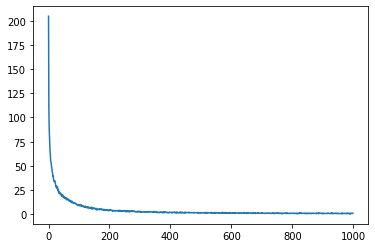

In [11]:
#We can plot the loss during the training process to visualize how the model adapts to the data.
plt.plot(history.history["loss"])
plt.show()

In [12]:
#As we might remember, the only trainable part of the model, was the one used to produce the embeddings.
#This part of the model is extracted and will be put into test usint the testing set.
model = net.get_layer(name="sequential")

In [13]:
#Since the data used for training was nornalized first, then we do the same with the testing set.
from sklearn.preprocessing import StandardScaler
x_test = StandardScaler().fit_transform(x_test) # normalizing the features

print(x_test.shape)

#We produce the new embeddings including the contextual information processed, to check its metrics.
result = model.predict(x_test)

print(result.shape)

(10246, 2060)
(10246, 2288)


In [14]:
#We use eucliudean distance, since is the kind of distance that was used during the training. And calculate every
#Distance between the images in the test set.

from sklearn.metrics.pairwise import euclidean_distances

result = np.array(result)
print(result)

distances = euclidean_distances(result, result)
print(distances.shape)

[[0.0000000e+00 7.1184027e-25 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 0.0000000e+00 ... 1.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [7.7558425e-23 1.0000000e+00 1.0000000e+00 ... 9.9999964e-01
  2.2253315e-01 1.0000000e+00]
 ...
 [3.2444925e-17 1.0000000e+00 1.0000000e+00 ... 1.4227146e-13
  1.4254775e-05 9.0945962e-10]
 [1.0000000e+00 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 1.0000000e+00
  0.0000000e+00 1.0000000e+00]]
(10246, 10246)


In [15]:
#For the test set, a subset of images needs to be selected as query, and the rest is used for the gallery, so no 
#image in the query should exist in the gallery, otherwise the distance would be zero. To ensure that this does 
#not happen, we first change the value to infinity to the distance of every image with itself.
querys = []
verification =  []
    
i = 0
for row in distances:
    row[i]=np.inf
    distances[i] = row
    i = i+1
    
random.seed(20)

#Then we take 20 percent of the test set for querys and the rest for gallery, as it is shown below.
numlst = list(range(len(distances))) 
random.shuffle(numlst)

split = int(len(distances)*0.2)

queryIndexes = numlst[:split]
     
#In order to calculate the metrics, we take a relevant subset of the ordered data, because at a certain point, the
#rest of the data is not relevant for mean Average Prceision calculation.
mostRelevantIndices = int(len(distances)*0.75)
    
for queryIndex in queryIndexes:
    top_20_idx = np.argsort(distances[queryIndex])[:mostRelevantIndices]
    top_20_values = [distances[queryIndex][i] for i in top_20_idx]
    querys.append(top_20_idx)
    verification.append(top_20_values)

In [16]:
eucDist = [] 
areSame = []
qI = []
rI = []
Id = y_test

#We calculate for each query image against the gallery, its most closest (and therefore more similar) images. Then
#we verify if they are the same, and save the query and gallery indexes, as well as the distances between them.
i = 0
for query in querys:
    for j in range(mostRelevantIndices):
        eucDist.append(verification[i][j])
        areSame.append(int(y_test[query[j]]==y_test[queryIndexes[i]]))
        qI.append(y_test[queryIndexes[i]])
        rI.append(y_test[query[j]])
    i=i+1
    
data3Final = []
data3Final = pd.DataFrame(data3Final)

data3Final['eucDist'] = eucDist
data3Final['areSame'] = areSame
data3Final['qI'] = qI
data3Final['rI'] = rI

print(data3Final)

            eucDist  areSame   qI   rI
0          2.287136        1  120  120
1          2.419138        1  120  120
2          2.570804        1  120  120
3          2.613768        1  120  120
4          2.650721        1  120  120
...             ...      ...  ...  ...
15744511  33.879154        0  406   78
15744512  33.879162        0  406   39
15744513  33.879261        0  406   35
15744514  33.879639        0  406  119
15744515  33.879684        0  406  416

[15744516 rows x 4 columns]


In [17]:
from argparse import ArgumentParser, FileType
from importlib import import_module
from itertools import count
import os

import json
import numpy as np
from sklearn.metrics import average_precision_score

average_precision = average_precision_score

# Loop over the query embeddings and compute their APs and the CMC curve.
aps = []
cmc = np.zeros(split, dtype=np.int32)

distances = np.array(data3Final['eucDist'])
pid_matches = np.array(data3Final['areSame'])

print(pid_matches)

[1 1 1 ... 0 0 0]


In [18]:
scores = 1 / (1 + distances)

for i in range(split):
    ap = average_precision(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices], scores[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices])

    if np.isnan(ap):
        print()
        print("WARNING: encountered an AP of NaN!")
        print("This usually means a person only appears once.")
        print("In this case, it's because of {}.".format(i))
        print("I'm excluding this person from eval and carrying on.")
        print()
        continue

    aps.append(ap)
    # Find the first true match and increment the cmc data from there on.
    try:
        k = np.where(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices] == 1)[0][0]
    except:
        k = -1
    cmc[k:] += 1

# Compute the actual cmc and mAP values
cmc = cmc / split
mean_ap = np.mean(aps)

# Save important data
#if args.filename is not None:
#    json.dump({'mAP': mean_ap, 'CMC': list(cmc), 'aps': list(aps)}, args.filename)

# Print out a short summary.
print('mAP: {:.2%} | top-1: {:.2%} top-2: {:.2%} | top-5: {:.2%} | top-10: {:.2%}'.format(mean_ap, cmc[0], cmc[1], cmc[4], cmc[9]))

/home/dell_mserver_01/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



This usually means a person only appears once.
In this case, it's because of 444.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 548.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 583.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 625.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 724.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 911.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 1022.
I'm excluding this person from eval and carrying on.


This usually means a person only appear

### Original evaluation

In [19]:
import torch
import csv
import numpy as np
import pandas as pd
from sklearn.utils import resample
import random
from sklearn.utils import shuffle

random.seed(20)

data = pd.read_csv('./9Data Features and Context csv/data3.csv', sep='|', low_memory=False)
data2 = pd.DataFrame(data)

#Data is randomized to partition for training and testing.
data2 = shuffle(data2, random_state = 20)
data2.reset_index(drop=True, inplace=True)

total_instances = len(data2['Id'])

train_test_split = int(total_instances*0.3)

#Removing the contextual data and only preserving the original embedding, as produced by the algorithm.
aditionalData = ["C", "Lat", "Long", "Time", "preInt", "temp", "hum", "press", "WindS", "WindG", "CloudC", "Visb"]

data2_feats = data2.drop(aditionalData, axis = 1)

y = np.array(data2['Id'])
x = data2_feats.loc[:, data2_feats.columns != 'Id']
x = np.array(x.loc[:, x.columns != 'I'])

x_test = x[:train_test_split]
y_test = y[:train_test_split]

print(x_test.shape)

(10246, 2048)


In [20]:
from sklearn.metrics.pairwise import euclidean_distances

result = np.array(x_test)
print(result)

distances = euclidean_distances(result, result)
print(distances.shape)

[[0.00350785 0.00874994 0.02433827 ... 0.00732256 0.00790363 0.00943384]
 [0.00441884 0.02455295 0.0119311  ... 0.004354   0.00990673 0.01079078]
 [0.00463692 0.01639946 0.02542835 ... 0.00758031 0.01131839 0.01143549]
 ...
 [0.00871846 0.03202007 0.01543241 ... 0.00550882 0.01021362 0.00696934]
 [0.00413221 0.01194421 0.01605299 ... 0.00297937 0.01189474 0.0063276 ]
 [0.00682689 0.01700663 0.01763614 ... 0.00566234 0.00733313 0.01064006]]
(10246, 10246)


In [21]:
querys = []
verification =  []

i = 0
for row in distances:
    row[i]=np.inf
    distances[i] = row
    i = i+1

random.seed(20)

numlst = list(range(len(distances))) 
random.shuffle(numlst)

split = int(len(distances)*0.2)

queryIndexes = numlst[:split]
     
mostRelevantIndices = int(len(distances)*0.75)
    
for queryIndex in queryIndexes:
    top_20_idx = np.argsort(distances[queryIndex])[:mostRelevantIndices]
    top_20_values = [distances[queryIndex][i] for i in top_20_idx]
    querys.append(top_20_idx)
    verification.append(top_20_values)

In [22]:
eucDist = [] 
areSame = []
qI = []
rI = []
Id = y_test
    
i = 0
for query in querys:
    for j in range(mostRelevantIndices):
        eucDist.append(verification[i][j])
        areSame.append(int(y_test[query[j]]==y_test[queryIndexes[i]]))
        qI.append(y_test[queryIndexes[i]])
        rI.append(y_test[query[j]])
    i=i+1
    
data3Final = []
data3Final = pd.DataFrame(data3Final)

data3Final['eucDist'] = eucDist
data3Final['areSame'] = areSame
data3Final['qI'] = qI
data3Final['rI'] = rI

print(data3Final)

           eucDist  areSame   qI   rI
0         0.123781        1  120  120
1         0.128055        1  120  120
2         0.138397        1  120  120
3         0.145875        1  120  120
4         0.155947        1  120  120
...            ...      ...  ...  ...
15744511  0.421817        0  406  236
15744512  0.421830        0  406  236
15744513  0.421841        0  406  149
15744514  0.421869        0  406  235
15744515  0.421875        0  406  383

[15744516 rows x 4 columns]


In [23]:
from argparse import ArgumentParser, FileType
from importlib import import_module
from itertools import count
import os

import json
import numpy as np
from sklearn.metrics import average_precision_score

average_precision = average_precision_score

# Loop over the query embeddings and compute their APs and the CMC curve.
aps = []
cmc = np.zeros(split, dtype=np.int32)

distances = np.array(data3Final['eucDist'])
pid_matches = np.array(data3Final['areSame'])

print(pid_matches)

[1 1 1 ... 0 0 0]


In [24]:
scores = 1 / (1 + distances)

for i in range(split):
    ap = average_precision(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices], scores[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices])

    if np.isnan(ap):
        print()
        print("WARNING: encountered an AP of NaN!")
        print("This usually means a person only appears once.")
        print("In this case, it's because of {}.".format(i))
        print("I'm excluding this person from eval and carrying on.")
        print()
        continue

    aps.append(ap)
    # Find the first true match and increment the cmc data from there on.
    try:
        k = np.where(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices] == 1)[0][0]
    except:
        k = -1
    cmc[k:] += 1

# Compute the actual cmc and mAP values
cmc = cmc / split
mean_ap = np.mean(aps)

# Save important data
#if args.filename is not None:
#    json.dump({'mAP': mean_ap, 'CMC': list(cmc), 'aps': list(aps)}, args.filename)

# Print out a short summary.
print('mAP: {:.2%} | top-1: {:.2%} top-2: {:.2%} | top-5: {:.2%} | top-10: {:.2%}'.format(mean_ap, cmc[0], cmc[1], cmc[4], cmc[9]))

/home/dell_mserver_01/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



This usually means a person only appears once.
In this case, it's because of 444.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 548.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 583.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 625.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 724.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 911.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 1022.
I'm excluding this person from eval and carrying on.


This usually means a person only appear

## Approach 2: MGN

In [1]:
import torch
import csv
import numpy as np
import pandas as pd
from sklearn.utils import resample
import tensorflow as tf
import random
from sklearn.utils import shuffle

#Loading the embedding features produced for this model along with Contextual Information 
#for each image in the dataset.
data = pd.read_csv('./9Data Features and Context csv/data3MGN.csv', sep='|', low_memory=False)
data2 = pd.DataFrame(data)

#Modifying range of values of Contextual Information from the data, according to its nature, to a range between 
#0 and 1 to fit the ranges of the embedding features.
data2['C'] = (data2['C'])/3.                      #There are only three possible cameras in the data
data2['Lat'] = (data2['Lat']+90)/180.             #Values go from -90 to 90. So a possible range of 180.
data2['Long'] = (data2['Long']+180)/360.          #Values go from -180 to 180. So a possible range of 360
diff = max(data2['Time'])-min(data2['Time'])      #Obtaining maximum and minimum time in seconds registered in the data.
val = min(data2['Time'])
data2['Time'] = (data2['Time']-val)/diff          #Subtracting the value its difference with zero, and then dividing by the differnce between maximum and minumum times reported
data2['preInt'] = (data2['preInt'])/100.          #Precipitation Intensity exists between 0 and 100
data2['temp'] = (data2['temp']+7.5)/55.           #Normal temperature varies between -7.5 and 47.5
data2['press'] = (data2['press'])-min(data2['press'])
data2['WindS'] = (data2['WindS']-2.8)/2.5         #Wind Speed varies between 2.8 and 5.3 
data2['WindG'] = (data2['WindG']-2.8)/2.5         #Wind Gust varies between 2.8 and 5.3
data2['Visb'] = (data2['Visb'])/296.              #Visibility values go from 0 to 296

#Data is randomized to partition for training and testing.
data2 = shuffle(data2, random_state = 20)
data2.reset_index(drop=True, inplace=True)

total_instances = len(data2['Id'])

train_test_split = int(total_instances*0.3)

#Removing the ID and I columns from the data that will be used to train and test the model.
#Correct Ids are saved as y.
y_train = np.array(data2['Id'])
x_train = data2.loc[:, data2.columns != 'Id']
x_train = np.array(x_train.loc[:, x_train.columns != 'I'])

#Since there are 501 IDS, we take 250 for training and 251 for testing.

x_test = x_train[:train_test_split]
x_train = x_train[train_test_split:]
        
y_test = y_train[:train_test_split]
y_train = y_train[train_test_split:]

# normalizing the features
from sklearn.preprocessing import StandardScaler
x_train = StandardScaler().fit_transform(x_train) 

print(x_train.shape)
print(x_test.shape)

(23910, 2060)
(10246, 2060)


In [2]:
#Batches creation, A random image from the training set is selected as well as another image from the same id, and
#an image of different Id.
def create_batch(batch_size):
    anchors = np.zeros((batch_size, 2060))
    positives = np.zeros((batch_size, 2060))
    negatives = np.zeros((batch_size, 2060))
    
    for i in range(0, batch_size):
        #Index of a random image is seleced
        index = random.randint(0, len(x_train) - 1)
        anc = x_train[index]
        #The real ID of the random image is used to guarantee that negative and positive images will be obtained.
        y = y_train[index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y)).reshape(-1,)
        indices_for_neg = np.squeeze(np.where(y_train != y)).reshape(-1,)
        
        pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos)-1)]]
        neg = x_train[indices_for_neg[random.randint(0, len(indices_for_neg)-1)]]

        #Anchor images, positives and negatives are saved and then returned.        
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg        
        
    return [anchors, positives, negatives]

In [3]:
#An embedding dimension is determined for the output of our network. Data will be processed simultaneously through 
#This network in order to learn the weights that let the representation be away from the different images and close
#To the similar images, thus, learning how to make use of contextual information provided.
emb_dim = 2288

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2288, activation='relu', input_shape=(2060,)),
    #tf.keras.layers.Dense(12, activation='relu', input_shape=(12,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2288)              4715568   
_________________________________________________________________
dense_1 (Dense)              (None, 2288)              5237232   
Total params: 9,952,800
Trainable params: 9,952,800
Non-trainable params: 0
_________________________________________________________________


In [4]:
#Testing the proper functioning of the model to produce the embeddings. (In this moment, with random weights).
example = x_train[0]

print(np.expand_dims(example, axis=0))

example_emb = embedding_model.predict(np.expand_dims(example, axis=0))[0]
print(example_emb)

[[ 0.67544334 -0.39237052 -0.71415887 ...  0.40815311 -1.
  -1.        ]]
[0.44991282 0.40698263 0.5548896  ... 0.42329842 0.68440443 0.36766252]


In [5]:
#The siamesse neural network structure is defined here. Three layers are used for input to the same embeddings
#model. This results are then fed to a concatenate layer, which produces the very same input but concatenated.

#Since this three embeddings are used to produce the output, and then to calculate the loss, this means that 
#the model is trained with the three data at the same time. Weights are shared, so if a change in the weigts 
#reduces the distance between the anchor and the positive, it should not affect the distance between the anchor 
#and the negative, otherwise, the loss function will not improve.
in_anc = tf.keras.layers.Input(shape=(2060,))
in_pos = tf.keras.layers.Input(shape=(2060,))
in_neg = tf.keras.layers.Input(shape=(2060,))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1)

net = tf.keras.models.Model(
    [in_anc, in_pos, in_neg],
    out
)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2060)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2060)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2060)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2288)         9952800     input_1[0][0]                    
                                                                 input_2[0][0]                

In [6]:
#Triplet_loss function definition, it receives a parameter alpha to determine the maximum negative distance that 
#can be produced by the embeddings, since the minimum positive distance would be idealy zero.
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        
        dp = tf.reduce_sum(tf.square(anc-pos), axis=1)        
        dn = tf.reduce_sum(tf.square(anc-neg), axis=1)

        return tf.maximum(dp - dn + alpha, 0.)
    return loss

In [7]:
#This function is a generator, which yields batches of triplets with the batch size indicated.
def data_generator(batch_size, emb_dim):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_dim))
        yield x, y

In [8]:
#The neural network is compiled, a batch size of 500 is defined, and a 1000 epoch training, with a number of steps
#per epoch that when multiplied by the number of batches, is similar to the number of data in the training set.
batch_size = 500
epochs = 1000
steps_per_epoch = int(len(x_train)/batch_size)

net.compile(loss=triplet_loss(alpha=1000,emb_dim=emb_dim), optimizer='adam')

In [9]:
#Finally the training is performed with the previously defined configurations.
history = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=True
)

  ...
    to  
  ['...']
Train for 47 steps
Epoch 1/1000
47/47 [==============================] - 9s 198ms/step - loss: 289.7782
Epoch 2/1000
47/47 [==============================] - 9s 188ms/step - loss: 145.6820
Epoch 3/1000
47/47 [==============================] - 9s 187ms/step - loss: 122.6481
Epoch 4/1000
47/47 [==============================] - 9s 189ms/step - loss: 113.5531
Epoch 5/1000
47/47 [==============================] - 9s 184ms/step - loss: 105.3136
Epoch 6/1000
47/47 [==============================] - 9s 187ms/step - loss: 96.5008
Epoch 7/1000
47/47 [==============================] - 9s 190ms/step - loss: 90.6893
Epoch 8/1000
47/47 [==============================] - 9s 186ms/step - loss: 86.4759
Epoch 9/1000
47/47 [==============================] - 9s 186ms/step - loss: 80.9145
Epoch 10/1000
47/47 [==============================] - 9s 188ms/step - loss: 77.3379
Epoch 11/1000
47/47 [==============================] - 9s 186ms/step - loss: 75.6876
Epoch 12/1000
47/47 [====

47/47 [==============================] - 8s 172ms/step - loss: 21.2952
Epoch 97/1000
47/47 [==============================] - 8s 172ms/step - loss: 20.8111
Epoch 98/1000
47/47 [==============================] - 8s 172ms/step - loss: 22.6122
Epoch 99/1000
47/47 [==============================] - 8s 173ms/step - loss: 20.8303
Epoch 100/1000
47/47 [==============================] - 8s 171ms/step - loss: 19.1700
Epoch 101/1000
47/47 [==============================] - 8s 172ms/step - loss: 20.4843
Epoch 102/1000
47/47 [==============================] - 8s 172ms/step - loss: 19.0515
Epoch 103/1000
47/47 [==============================] - 8s 172ms/step - loss: 19.2822
Epoch 104/1000
47/47 [==============================] - 8s 172ms/step - loss: 18.5566
Epoch 105/1000
47/47 [==============================] - 8s 172ms/step - loss: 18.3888
Epoch 106/1000
47/47 [==============================] - 8s 172ms/step - loss: 19.1336
Epoch 107/1000
47/47 [==============================] - 8s 171ms/step - 

47/47 [==============================] - 8s 168ms/step - loss: 10.2200
Epoch 192/1000
47/47 [==============================] - 8s 168ms/step - loss: 9.7323
Epoch 193/1000
47/47 [==============================] - 8s 168ms/step - loss: 10.3350
Epoch 194/1000
47/47 [==============================] - 8s 168ms/step - loss: 10.4760
Epoch 195/1000
47/47 [==============================] - 8s 168ms/step - loss: 9.3359
Epoch 196/1000
47/47 [==============================] - 8s 168ms/step - loss: 10.0134
Epoch 197/1000
47/47 [==============================] - 8s 168ms/step - loss: 9.5613
Epoch 198/1000
47/47 [==============================] - 8s 169ms/step - loss: 9.2625
Epoch 199/1000
47/47 [==============================] - 8s 168ms/step - loss: 9.5975
Epoch 200/1000
47/47 [==============================] - 8s 168ms/step - loss: 10.0731
Epoch 201/1000
47/47 [==============================] - 8s 168ms/step - loss: 9.6509
Epoch 202/1000
47/47 [==============================] - 8s 168ms/step - los

47/47 [==============================] - 8s 167ms/step - loss: 5.6112
Epoch 288/1000
47/47 [==============================] - 8s 167ms/step - loss: 5.7852
Epoch 289/1000
47/47 [==============================] - 8s 167ms/step - loss: 5.6529
Epoch 290/1000
47/47 [==============================] - 8s 169ms/step - loss: 5.7325
Epoch 291/1000
47/47 [==============================] - 8s 176ms/step - loss: 5.4674
Epoch 292/1000
47/47 [==============================] - 9s 184ms/step - loss: 5.0085
Epoch 293/1000
47/47 [==============================] - 8s 173ms/step - loss: 5.5012
Epoch 294/1000
47/47 [==============================] - 8s 172ms/step - loss: 5.4032
Epoch 295/1000
47/47 [==============================] - 8s 172ms/step - loss: 6.0236
Epoch 296/1000
47/47 [==============================] - 8s 172ms/step - loss: 5.9388
Epoch 297/1000
47/47 [==============================] - 8s 170ms/step - loss: 5.1930
Epoch 298/1000
47/47 [==============================] - 8s 170ms/step - loss: 5.

47/47 [==============================] - 8s 167ms/step - loss: 4.0366
Epoch 384/1000
47/47 [==============================] - 8s 168ms/step - loss: 4.3073
Epoch 385/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.8591
Epoch 386/1000
47/47 [==============================] - 8s 167ms/step - loss: 4.2171
Epoch 387/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.8467
Epoch 388/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.8781
Epoch 389/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.3449
Epoch 390/1000
47/47 [==============================] - 8s 168ms/step - loss: 4.1867
Epoch 391/1000
47/47 [==============================] - 8s 167ms/step - loss: 4.5861
Epoch 392/1000
47/47 [==============================] - 8s 167ms/step - loss: 4.2378
Epoch 393/1000
47/47 [==============================] - 8s 168ms/step - loss: 3.6458
Epoch 394/1000
47/47 [==============================] - 8s 168ms/step - loss: 3.

47/47 [==============================] - 8s 167ms/step - loss: 3.0164
Epoch 480/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.0210
Epoch 481/1000
47/47 [==============================] - 8s 167ms/step - loss: 2.8813
Epoch 482/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.4981
Epoch 483/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.3717
Epoch 484/1000
47/47 [==============================] - 8s 167ms/step - loss: 2.9174
Epoch 485/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.1103
Epoch 486/1000
47/47 [==============================] - 8s 167ms/step - loss: 2.6858
Epoch 487/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.1072
Epoch 488/1000
47/47 [==============================] - 8s 167ms/step - loss: 2.5506
Epoch 489/1000
47/47 [==============================] - 8s 167ms/step - loss: 2.9654
Epoch 490/1000
47/47 [==============================] - 8s 167ms/step - loss: 3.

47/47 [==============================] - 8s 167ms/step - loss: 2.4613
Epoch 576/1000
47/47 [==============================] - 8s 167ms/step - loss: 2.1323
Epoch 577/1000
47/47 [==============================] - 8s 167ms/step - loss: 2.0391
Epoch 578/1000
47/47 [==============================] - 8s 168ms/step - loss: 2.3324
Epoch 579/1000
47/47 [==============================] - 8s 167ms/step - loss: 1.9987
Epoch 580/1000
47/47 [==============================] - 8s 167ms/step - loss: 1.8872
Epoch 581/1000
47/47 [==============================] - 8s 167ms/step - loss: 2.4639
Epoch 582/1000
47/47 [==============================] - 8s 167ms/step - loss: 2.4937
Epoch 583/1000
47/47 [==============================] - 8s 173ms/step - loss: 2.0572
Epoch 584/1000
47/47 [==============================] - 9s 182ms/step - loss: 1.9306
Epoch 585/1000
47/47 [==============================] - 8s 180ms/step - loss: 2.0721
Epoch 586/1000
47/47 [==============================] - 8s 180ms/step - loss: 2.

47/47 [==============================] - 8s 166ms/step - loss: 1.7632
Epoch 672/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.8622
Epoch 673/1000
47/47 [==============================] - 8s 166ms/step - loss: 2.3151
Epoch 674/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.5950
Epoch 675/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.7783
Epoch 676/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.5490
Epoch 677/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.9115
Epoch 678/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.6101
Epoch 679/1000
47/47 [==============================] - 8s 167ms/step - loss: 1.9976
Epoch 680/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.6001
Epoch 681/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.4800
Epoch 682/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.

47/47 [==============================] - 8s 168ms/step - loss: 1.6767
Epoch 768/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.4096
Epoch 769/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.6970
Epoch 770/1000
47/47 [==============================] - 8s 169ms/step - loss: 1.7929
Epoch 771/1000
47/47 [==============================] - 8s 169ms/step - loss: 1.4892
Epoch 772/1000
47/47 [==============================] - 8s 169ms/step - loss: 1.6299
Epoch 773/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.3570
Epoch 774/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.3657
Epoch 775/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.3578
Epoch 776/1000
47/47 [==============================] - 8s 170ms/step - loss: 1.7596
Epoch 777/1000
47/47 [==============================] - 8s 170ms/step - loss: 1.5054
Epoch 778/1000
47/47 [==============================] - 8s 170ms/step - loss: 1.

47/47 [==============================] - 8s 168ms/step - loss: 1.2779
Epoch 864/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.1420
Epoch 865/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.1469
Epoch 866/1000
47/47 [==============================] - 8s 169ms/step - loss: 1.2093
Epoch 867/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.3508
Epoch 868/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.5588
Epoch 869/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.4526
Epoch 870/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.1300
Epoch 871/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.3463
Epoch 872/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.3080
Epoch 873/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.2927
Epoch 874/1000
47/47 [==============================] - 8s 168ms/step - loss: 1.

47/47 [==============================] - 8s 166ms/step - loss: 1.2684
Epoch 960/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.1080
Epoch 961/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.3567
Epoch 962/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.6155
Epoch 963/1000
47/47 [==============================] - 8s 166ms/step - loss: 0.9914
Epoch 964/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.3834
Epoch 965/1000
47/47 [==============================] - 8s 165ms/step - loss: 1.0235
Epoch 966/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.5457
Epoch 967/1000
47/47 [==============================] - 8s 166ms/step - loss: 1.5630
Epoch 968/1000
47/47 [==============================] - 8s 166ms/step - loss: 0.7583
Epoch 969/1000
47/47 [==============================] - 8s 168ms/step - loss: 0.8152
Epoch 970/1000
47/47 [==============================] - 8s 168ms/step - loss: 0.

In [10]:
#We can plot the loss during the training process to visualize how the model adapts to the data.
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.show()

<Figure size 640x480 with 1 Axes>

In [11]:
#As we might remember, the only trainable part of the model, was the one used to produce the embeddings.
#This part of the model is extracted and will be put into test usint the testing set.
model = net.get_layer(name="sequential")

In [12]:
#Since the data used for training was nornalized first, then we do the same with the testing set.
from sklearn.preprocessing import StandardScaler
x_test = StandardScaler().fit_transform(x_test) # normalizing the features

print(x_test.shape)

#We produce the new embeddings including the contextual information processed, to check its metrics.
result = model.predict(x_test)

print(result.shape)

(10246, 2060)
(10246, 2288)


In [13]:
#We use eucliudean distance, since is the kind of distance that was used during the training. And calculate every
#Distance between the images in the test set.
result = np.array(result)

distances = []
i = 0
for val1 in result:
    distances.append([])
    for val2 in result:
        distances[i].append(np.sum(np.square(val1-val2)))
    i = i+1

print(distances[0])

[0.0, 1181.2225, 1139.7527, 1079.267, 1147.3564, 1060.9268, 1143.7305, 1079.9296, 1176.9866, 1195.2036, 1080.9763, 1.000147, 1076.7039, 1091.0541, 1110.8136, 1198.7968, 1092.4897, 1131.6381, 1097.9215, 1079.7427, 1096.4739, 1110.7775, 1075.9237, 1086.1719, 1112.2927, 1130.6355, 1066.1848, 1098.2545, 26.99493, 1084.9281, 944.02026, 1140.8928, 1063.3599, 1210.376, 1171.1248, 1126.6517, 1080.4504, 1081.3586, 1059.9437, 1159.1305, 1096.8157, 1044.814, 1062.9266, 1190.9941, 1162.7322, 990.9513, 1078.9277, 1079.8291, 1080.0283, 1081.9287, 1111.6888, 1048.8972, 1063.9268, 1096.9286, 1187.9081, 1198.4536, 1062.5483, 1142.5364, 1043.0625, 1102.2632, 1124.9788, 1289.273, 2.0579615, 1078.9009, 1072.3959, 1111.3069, 1085.898, 1108.2831, 1188.2693, 1080.7239, 1093.2256, 1139.9154, 1069.6318, 1.0085144, 1070.1465, 1096.3628, 1233.8794, 1074.9297, 1202.1573, 1077.9099, 1188.4788, 1096.0286, 1098.3057, 1059.8333, 1046.9343, 1079.1626, 1108.8572, 1164.0535, 1085.9204, 1110.2079, 1168.3057, 1079.2667, 1

In [14]:
#For the test set, a subset of images needs to be selected as query, and the rest is used for the gallery, so no 
#image in the query should exist in the gallery, otherwise the distance would be zero. To ensure that this does 
#not happen, we first change the value to infinity to the distance of every image with itself.
querys = []
verification =  []
    
i = 0
for row in distances:
    row[i]=np.inf
    distances[i] = row
    i = i+1
    
random.seed(20)

#Then we take 20 percent of the test set for querys and the rest for gallery, as it is shown below.
numlst = list(range(len(distances))) 
random.shuffle(numlst)

split = int(len(distances)*0.2)

queryIndexes = numlst[:split]

#In order to calculate the metrics, we take a relevant subset of the ordered data, because at a certain point, the
#rest of the data is not relevant for mean Average Prceision calculation.

mostRelevantIndices = int(len(distances)*0.2)
    
for queryIndex in queryIndexes:
    top_20_idx = np.argsort(distances[queryIndex])[:mostRelevantIndices]
    top_20_values = [distances[queryIndex][i] for i in top_20_idx]
    querys.append(top_20_idx)
    verification.append(top_20_values)

In [15]:
eucDist = [] 
areSame = []
qI = []
rI = []
Id = y_test

#We calculate for each query image against the gallery, its most closest (and therefore more similar) images. Then
#we verify if they are the same, and save the query and gallery indexes, as well as the distances between them.
i = 0
for query in querys:
    for j in range(mostRelevantIndices):
        eucDist.append(verification[i][j])
        areSame.append(int(y_test[query[j]]==y_test[queryIndexes[i]]))
        qI.append(y_test[queryIndexes[i]])
        rI.append(y_test[query[j]])
    i=i+1
    
data3Final = []
data3Final = pd.DataFrame(data3Final)

data3Final['eucDist'] = eucDist
data3Final['areSame'] = areSame
data3Final['qI'] = qI
data3Final['rI'] = rI

print(data3Final)

             eucDist  areSame   qI   rI
0           1.710939        1  120  120
1           2.041882        1  120  120
2           3.226616        1  120  120
3           3.658428        1  120  120
4           4.030130        1  120  120
...              ...      ...  ...  ...
4198396  1090.927002        0  406  236
4198397  1090.928711        0  406  236
4198398  1090.929199        0  406  236
4198399  1090.929321        0  406  296
4198400  1090.935425        0  406  296

[4198401 rows x 4 columns]


In [16]:
from argparse import ArgumentParser, FileType
from importlib import import_module
from itertools import count
import os

import json
import numpy as np
from sklearn.metrics import average_precision_score

average_precision = average_precision_score

# Loop over the query embeddings and compute their APs and the CMC curve.
aps = []
cmc = np.zeros(split, dtype=np.int32)

distances = np.array(data3Final['eucDist'])
pid_matches = np.array(data3Final['areSame'])

print(pid_matches)

[1 1 1 ... 0 0 0]


In [17]:
scores = 1 / (1 + distances)

for i in range(split):
    ap = average_precision(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices], scores[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices])

    if np.isnan(ap):
        print()
        print("WARNING: encountered an AP of NaN!")
        print("This usually means a person only appears once.")
        print("In this case, it's because of {}.".format(i))
        print("I'm excluding this person from eval and carrying on.")
        print()
        continue

    aps.append(ap)
    # Find the first true match and increment the cmc data from there on.
    try:
        k = np.where(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices] == 1)[0][0]
    except:
        k = -1
    cmc[k:] += 1

# Compute the actual cmc and mAP values
cmc = cmc / split
mean_ap = np.mean(aps)

# Save important data
#if args.filename is not None:
#    json.dump({'mAP': mean_ap, 'CMC': list(cmc), 'aps': list(aps)}, args.filename)

# Print out a short summary.
print('mAP: {:.2%} | top-1: {:.2%} top-2: {:.2%} | top-5: {:.2%} | top-10: {:.2%}'.format(mean_ap, cmc[0], cmc[1], cmc[4], cmc[9]))


This usually means a person only appears once.
In this case, it's because of 444.
I'm excluding this person from eval and carrying on.



/home/dell_mserver_01/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



This usually means a person only appears once.
In this case, it's because of 548.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 583.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 625.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 724.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 911.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 1022.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 1184.
I'm excluding this person from eval and carrying on.


This usually means a person only appea

### Original evaluation

In [18]:
import torch
import csv
import numpy as np
import pandas as pd
from sklearn.utils import resample

random.seed(20)

data = pd.read_csv('./9Data Features and Context csv/data3MGN.csv', sep='|', low_memory=False)
data2 = pd.DataFrame(data)

#Data is randomized to partition for training and testing.
data2 = shuffle(data2, random_state = 20)
data2.reset_index(drop=True, inplace=True)

total_instances = len(data2['Id'])

train_test_split = int(total_instances*0.3)

#Removing the contextual data and only preserving the original embedding, as produced by the algorithm.
aditionalData = ["C", "Lat", "Long", "Time", "preInt", "temp", "hum", "press", "WindS", "WindG", "CloudC", "Visb"]

data2_feats = data2.drop(aditionalData, axis = 1)

y = np.array(data2['Id'])
x = data2_feats.loc[:, data2_feats.columns != 'Id']
x = np.array(x.loc[:, x.columns != 'I'])

x_test = x[:train_test_split]
y_test = y[:train_test_split]

print(x_test.shape)

(10246, 2048)


In [19]:
from sklearn.metrics.pairwise import euclidean_distances

result = np.array(x_test)
print(result)

distances = []
i = 0
for val1 in result:
    distances.append([])
    for val2 in result:
        distances[i].append(np.sum(np.square(val1-val2)))
    i = i+1

#print(distances[0])

#distances = euclidean_distances(result, result)
#print(distances.shape)

[[0.00350785 0.00874994 0.02433827 ... 0.00732256 0.00790363 0.00943384]
 [0.00441884 0.02455295 0.0119311  ... 0.004354   0.00990673 0.01079078]
 [0.00463692 0.01639946 0.02542835 ... 0.00758031 0.01131839 0.01143549]
 ...
 [0.00871846 0.03202007 0.01543241 ... 0.00550882 0.01021362 0.00696934]
 [0.00413221 0.01194421 0.01605299 ... 0.00297937 0.01189474 0.0063276 ]
 [0.00682689 0.01700663 0.01763614 ... 0.00566234 0.00733313 0.01064006]]


In [20]:
querys = []
verification =  []

i = 0
for row in distances:
    row[i]=np.inf
    distances[i] = row
    i = i+1

random.seed(20)

numlst = list(range(len(distances))) 
random.shuffle(numlst)

split = int(len(distances)*0.2)

queryIndexes = numlst[:split]
     
mostRelevantIndices = int(len(distances)*0.2)
    
for queryIndex in queryIndexes:
    top_20_idx = np.argsort(distances[queryIndex])[:mostRelevantIndices]
    top_20_values = [distances[queryIndex][i] for i in top_20_idx]
    querys.append(top_20_idx)
    verification.append(top_20_values)

In [21]:
eucDist = [] 
areSame = []
qI = []
rI = []
Id = y_test
    
i = 0
for query in querys:
    for j in range(mostRelevantIndices):
        eucDist.append(verification[i][j])
        areSame.append(int(y_test[query[j]]==y_test[queryIndexes[i]]))
        qI.append(y_test[queryIndexes[i]])
        rI.append(y_test[query[j]])
    i=i+1
    
data3Final = []
data3Final = pd.DataFrame(data3Final)

data3Final['eucDist'] = eucDist
data3Final['areSame'] = areSame
data3Final['qI'] = qI
data3Final['rI'] = rI

print(data3Final)

          eucDist  areSame   qI   rI
0        0.086700        1  120  120
1        0.097321        1  120  120
2        0.126273        1  120  120
3        0.149538        1  120  120
4        0.157916        1  120  120
...           ...      ...  ...  ...
4198396  1.025314        0  406   31
4198397  1.025318        0  406  412
4198398  1.025318        0  406  157
4198399  1.025328        0  406  158
4198400  1.025338        0  406  412

[4198401 rows x 4 columns]


In [22]:
from argparse import ArgumentParser, FileType
from importlib import import_module
from itertools import count
import os

import json
import numpy as np
from sklearn.metrics import average_precision_score

average_precision = average_precision_score

# Loop over the query embeddings and compute their APs and the CMC curve.
aps = []
cmc = np.zeros(split, dtype=np.int32)

distances = np.array(data3Final['eucDist'])
pid_matches = np.array(data3Final['areSame'])

print(pid_matches)

[1 1 1 ... 0 0 0]


In [23]:
scores = 1 / (1 + distances)

for i in range(split):
    ap = average_precision(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices], scores[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices])

    if np.isnan(ap):
        print()
        print("WARNING: encountered an AP of NaN!")
        print("This usually means a person only appears once.")
        print("In this case, it's because of {}.".format(i))
        print("I'm excluding this person from eval and carrying on.")
        print()
        continue

    aps.append(ap)
    # Find the first true match and increment the cmc data from there on.
    try:
        k = np.where(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices] == 1)[0][0]
    except:
        k = -1
    cmc[k:] += 1

# Compute the actual cmc and mAP values
cmc = cmc / split
mean_ap = np.mean(aps)

# Save important data
#if args.filename is not None:
#    json.dump({'mAP': mean_ap, 'CMC': list(cmc), 'aps': list(aps)}, args.filename)

# Print out a short summary.
print('mAP: {:.2%} | top-1: {:.2%} top-2: {:.2%} | top-5: {:.2%} | top-10: {:.2%}'.format(mean_ap, cmc[0], cmc[1], cmc[4], cmc[9]))


This usually means a person only appears once.
In this case, it's because of 44.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 206.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 255.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 444.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 533.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 548.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 583.
I'm excluding this person from eval and carrying on.


This usually means a person only appears 

## Approach 3: MLFN Model

In [48]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import torch
import csv
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.utils import shuffle

#Loading the embedding features produced for this model along with Contextual Information 
#for each image in the dataset.
data = pd.read_csv('./9Data Features and Context csv/data3MLFN.csv', sep='|', low_memory=False)
data2 = pd.DataFrame(data)

#Modifying range of values of Contextual Information from the data, according to its nature, to a range between 
#0 and 1 to fit the ranges of the embedding features.
data2['C'] = (data2['C'])/3.                      #There are only three possible cameras in the data
data2['Lat'] = (data2['Lat']+90)/180.             #Values go from -90 to 90. So a possible range of 180.
data2['Long'] = (data2['Long']+180)/360.          #Values go from -180 to 180. So a possible range of 360
diff = max(data2['Time'])-min(data2['Time'])      #Obtaining maximum and minimum time in seconds registered in the data.
val = min(data2['Time'])
data2['Time'] = (data2['Time']-val)/diff          #Subtracting the value its difference with zero, and then dividing by the differnce between maximum and minumum times reported
data2['preInt'] = (data2['preInt'])/100.          #Precipitation Intensity exists between 0 and 100
data2['temp'] = (data2['temp']+7.5)/55.           #Normal temperature varies between -7.5 and 47.5
data2['press'] = (data2['press'])-min(data2['press'])
data2['WindS'] = (data2['WindS']-2.8)/2.5         #Wind Speed varies between 2.8 and 5.3 
data2['WindG'] = (data2['WindG']-2.8)/2.5         #Wind Gust varies between 2.8 and 5.3
data2['Visb'] = (data2['Visb'])/296.              #Visibility values go from 0 to 296

#Data is randomized to partition for training and testing.
data2 = shuffle(data2, random_state = 15)
data2.reset_index(drop=True, inplace=True)

total_instances = len(data2['Id'])

train_test_split = int(total_instances*0.3)

#Removing the ID and I columns from the data that will be used to train and test the model.
#Correct Ids are saved as y.
y_train = np.array(data2['Id'])
x_train = data2.loc[:, data2.columns != 'Id']
x_train = np.array(x_train.loc[:, x_train.columns != 'I'])

#Since there are 501 IDS, we take 250 for training and 251 for testing.
x_test = x_train[:train_test_split]
x_train = x_train[train_test_split:]
        
y_test = y_train[:train_test_split]
y_train = y_train[train_test_split:]

# normalizing the features
from sklearn.preprocessing import StandardScaler
x_train = StandardScaler().fit_transform(x_train) 

print(x_train.shape)
print(x_test.shape)

(23910, 1036)
(10246, 1036)


In [49]:
#Batches creation, A random image from the training set is selected as well as another image from the same id, and
#an image of different Id.
def create_batch(batch_size):
    anchors = np.zeros((batch_size, 1036))
    positives = np.zeros((batch_size, 1036))
    negatives = np.zeros((batch_size, 1036))
    
    for i in range(0, batch_size):
        #Index of a random image is seleced
        index = random.randint(0, len(x_train) - 1)
        anc = x_train[index]
        #The real ID of the random image is used to guarantee that negative and positive images will be obtained.
        y = y_train[index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y)).reshape(-1,)
        indices_for_neg = np.squeeze(np.where(y_train != y)).reshape(-1,)
        
        pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos)-1)]]
        neg = x_train[indices_for_neg[random.randint(0, len(indices_for_neg)-1)]]
        
        #Anchor images, positives and negatives are saved and then returned.
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        
    return [anchors, positives, negatives]

In [50]:
#An embedding dimension is determined for the output of our network. Data will be processed simultaneously through 
#This network in order to learn the weights that let the representation be away from the different images and close
#To the similar images, thus, learning how to make use of contextual information provided.
emb_dim = 2288

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2288, activation='relu', input_shape=(1036,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2288)              2372656   
_________________________________________________________________
dense_5 (Dense)              (None, 2288)              5237232   
Total params: 7,609,888
Trainable params: 7,609,888
Non-trainable params: 0
_________________________________________________________________


In [51]:
#Testing the proper functioning of the model to produce the embeddings. (In this moment, with random weights).
example = x_train[0]

print(np.expand_dims(example, axis=0))

example_emb = embedding_model.predict(np.expand_dims(example, axis=0))[0]
print(example_emb)

[[ 0.68085488 -0.39390938 -0.72033613 ...  0.41135803 -1.
  -1.        ]]
[0.5065828  0.402161   0.5645894  ... 0.37127504 0.5547778  0.6481188 ]


In [52]:
#The siamesse neural network structure is defined here. Three layers are used for input to the same embeddings
#model. This results are then fed to a concatenate layer, which produces the very same input but concatenated.

#Since this three embeddings are used to produce the output, and then to calculate the loss, this means that 
#the model is trained with the three data at the same time. Weights are shared, so if a change in the weigts 
#reduces the distance between the anchor and the positive, it should not affect the distance between the anchor 
#and the negative, otherwise, the loss function will not improve.
in_anc = tf.keras.layers.Input(shape=(1036,))
in_pos = tf.keras.layers.Input(shape=(1036,))
in_neg = tf.keras.layers.Input(shape=(1036,))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1)

net = tf.keras.models.Model(
    [in_anc, in_pos, in_neg],
    out
)
net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1036)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1036)]       0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1036)]       0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 2288)         7609888     input_7[0][0]                    
                                                                 input_8[0][0]              

In [53]:
#Triplet_loss function definition, it receives a parameter alpha to determine the maximum negative distance that 
#can be produced by the embeddings, since the minimum positive distance would be idealy zero.
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        dp = tf.reduce_sum(tf.square(anc-pos), axis=1)
        dn = tf.reduce_sum(tf.square(anc-neg), axis=1)

        return tf.maximum(dp - dn + alpha, 0.)
    return loss

In [54]:
#This function is a generator, which yields batches of triplets with the batch size indicated.
def data_generator(batch_size, emb_dim):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_dim))
        yield x, y

In [55]:
#The neural network is compiled, a batch size of 500 is defined, and a 1000 epoch training, with a number of steps
#per epoch that when multiplied by the number of batches, is similar to the number of data in the training set.
batch_size = 500
epochs = 1000
steps_per_epoch = int(len(x_train)/batch_size)

net.compile(loss=triplet_loss(alpha=1000, emb_dim=emb_dim), optimizer='adam')

In [56]:
#Finally the training is performed with the previously defined configurations.
history = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=True
)

  ...
    to  
  ['...']
Train for 47 steps
Epoch 1/1000
47/47 [==============================] - 8s 164ms/step - loss: 223.9932
Epoch 2/1000
47/47 [==============================] - 6s 137ms/step - loss: 108.2612
Epoch 3/1000
47/47 [==============================] - 6s 137ms/step - loss: 89.6914
Epoch 4/1000
47/47 [==============================] - 6s 137ms/step - loss: 78.0908
Epoch 5/1000
47/47 [==============================] - 6s 137ms/step - loss: 73.5925
Epoch 6/1000
47/47 [==============================] - 7s 139ms/step - loss: 64.7320
Epoch 7/1000
47/47 [==============================] - 7s 139ms/step - loss: 61.0661
Epoch 8/1000
47/47 [==============================] - 7s 140ms/step - loss: 57.2525
Epoch 9/1000
47/47 [==============================] - 7s 140ms/step - loss: 54.0884
Epoch 10/1000
47/47 [==============================] - 7s 140ms/step - loss: 50.4688
Epoch 11/1000
47/47 [==============================] - 7s 140ms/step - loss: 48.4294
Epoch 12/1000
47/47 [=======

47/47 [==============================] - 7s 140ms/step - loss: 8.5386
Epoch 97/1000
47/47 [==============================] - 7s 140ms/step - loss: 9.2926
Epoch 98/1000
47/47 [==============================] - 7s 140ms/step - loss: 8.7301
Epoch 99/1000
47/47 [==============================] - 7s 140ms/step - loss: 8.7146
Epoch 100/1000
47/47 [==============================] - 7s 140ms/step - loss: 8.6956
Epoch 101/1000
47/47 [==============================] - 7s 139ms/step - loss: 8.0244
Epoch 102/1000
47/47 [==============================] - 7s 140ms/step - loss: 8.9036
Epoch 103/1000
47/47 [==============================] - 7s 140ms/step - loss: 8.9620
Epoch 104/1000
47/47 [==============================] - 7s 140ms/step - loss: 7.9315
Epoch 105/1000
47/47 [==============================] - 7s 140ms/step - loss: 8.1218
Epoch 106/1000
47/47 [==============================] - 7s 139ms/step - loss: 7.3523
Epoch 107/1000
47/47 [==============================] - 7s 140ms/step - loss: 7.907

47/47 [==============================] - 7s 138ms/step - loss: 3.7418
Epoch 193/1000
47/47 [==============================] - 6s 138ms/step - loss: 3.5254
Epoch 194/1000
47/47 [==============================] - 6s 138ms/step - loss: 4.0127
Epoch 195/1000
47/47 [==============================] - 7s 138ms/step - loss: 3.4898
Epoch 196/1000
47/47 [==============================] - 7s 139ms/step - loss: 3.8137
Epoch 197/1000
47/47 [==============================] - 7s 139ms/step - loss: 3.5773
Epoch 198/1000
47/47 [==============================] - 6s 138ms/step - loss: 3.1468
Epoch 199/1000
47/47 [==============================] - 7s 138ms/step - loss: 3.7082
Epoch 200/1000
47/47 [==============================] - 6s 138ms/step - loss: 3.8755
Epoch 201/1000
47/47 [==============================] - 6s 138ms/step - loss: 3.2624
Epoch 202/1000
47/47 [==============================] - 6s 138ms/step - loss: 4.0430
Epoch 203/1000
47/47 [==============================] - 7s 138ms/step - loss: 3.

47/47 [==============================] - 6s 138ms/step - loss: 2.4361
Epoch 289/1000
47/47 [==============================] - 6s 138ms/step - loss: 2.4370
Epoch 290/1000
47/47 [==============================] - 6s 138ms/step - loss: 2.6272
Epoch 291/1000
47/47 [==============================] - 6s 138ms/step - loss: 2.2703
Epoch 292/1000
47/47 [==============================] - 6s 138ms/step - loss: 2.5319
Epoch 293/1000
47/47 [==============================] - 6s 138ms/step - loss: 2.3709
Epoch 294/1000
47/47 [==============================] - 6s 138ms/step - loss: 2.2930
Epoch 295/1000
47/47 [==============================] - 6s 138ms/step - loss: 2.7661
Epoch 296/1000
47/47 [==============================] - 6s 138ms/step - loss: 2.5161
Epoch 297/1000
47/47 [==============================] - 6s 138ms/step - loss: 2.6581
Epoch 298/1000
47/47 [==============================] - 6s 138ms/step - loss: 2.7604
Epoch 299/1000
47/47 [==============================] - 6s 138ms/step - loss: 2.

47/47 [==============================] - 6s 137ms/step - loss: 1.4063
Epoch 385/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.9734
Epoch 386/1000
47/47 [==============================] - 6s 137ms/step - loss: 2.3749
Epoch 387/1000
47/47 [==============================] - 6s 136ms/step - loss: 2.1200
Epoch 388/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.7442
Epoch 389/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.6581
Epoch 390/1000
47/47 [==============================] - 6s 137ms/step - loss: 2.1137
Epoch 391/1000
47/47 [==============================] - 6s 137ms/step - loss: 2.6167
Epoch 392/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.7748
Epoch 393/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.8906
Epoch 394/1000
47/47 [==============================] - 6s 137ms/step - loss: 2.2033
Epoch 395/1000
47/47 [==============================] - 6s 137ms/step - loss: 2.

47/47 [==============================] - 6s 137ms/step - loss: 1.5589
Epoch 481/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.4285
Epoch 482/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.9439
Epoch 483/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.4729
Epoch 484/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.4426
Epoch 485/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.4527
Epoch 486/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.6290
Epoch 487/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.8366
Epoch 488/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.6217
Epoch 489/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.6935
Epoch 490/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.9106
Epoch 491/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.

47/47 [==============================] - 6s 136ms/step - loss: 1.4067
Epoch 577/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.6502
Epoch 578/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.8647
Epoch 579/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.7997
Epoch 580/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.5081
Epoch 581/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.7283
Epoch 582/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.5453
Epoch 583/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.5618
Epoch 584/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.3145
Epoch 585/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.6899
Epoch 586/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.2725
Epoch 587/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.

47/47 [==============================] - 6s 136ms/step - loss: 1.1839
Epoch 673/1000
47/47 [==============================] - 6s 137ms/step - loss: 0.8640
Epoch 674/1000
47/47 [==============================] - 6s 137ms/step - loss: 0.9118
Epoch 675/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.2011
Epoch 676/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.0014
Epoch 677/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.1587
Epoch 678/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.1679
Epoch 679/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.3289
Epoch 680/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.6798
Epoch 681/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.3149
Epoch 682/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.5529
Epoch 683/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.

47/47 [==============================] - 6s 137ms/step - loss: 1.0132
Epoch 769/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.0868
Epoch 770/1000
47/47 [==============================] - 6s 136ms/step - loss: 0.9221
Epoch 771/1000
47/47 [==============================] - 6s 136ms/step - loss: 0.8078
Epoch 772/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.3656
Epoch 773/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.1253
Epoch 774/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.0442
Epoch 775/1000
47/47 [==============================] - 6s 136ms/step - loss: 0.9878
Epoch 776/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.3601
Epoch 777/1000
47/47 [==============================] - 6s 136ms/step - loss: 0.9407
Epoch 778/1000
47/47 [==============================] - 6s 136ms/step - loss: 0.8353
Epoch 779/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.

47/47 [==============================] - 6s 136ms/step - loss: 1.0366
Epoch 865/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.0380
Epoch 866/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.2665
Epoch 867/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.2428
Epoch 868/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.0651
Epoch 869/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.1056
Epoch 870/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.0225
Epoch 871/1000
47/47 [==============================] - 6s 137ms/step - loss: 0.7384
Epoch 872/1000
47/47 [==============================] - 6s 137ms/step - loss: 0.9093
Epoch 873/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.1392
Epoch 874/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.1635
Epoch 875/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.

47/47 [==============================] - 6s 137ms/step - loss: 1.6482
Epoch 961/1000
47/47 [==============================] - 6s 137ms/step - loss: 1.0152
Epoch 962/1000
47/47 [==============================] - 6s 137ms/step - loss: 0.8220
Epoch 963/1000
47/47 [==============================] - 6s 137ms/step - loss: 0.6386
Epoch 964/1000
47/47 [==============================] - 6s 136ms/step - loss: 0.8408
Epoch 965/1000
47/47 [==============================] - 6s 136ms/step - loss: 1.0059
Epoch 966/1000
47/47 [==============================] - 6s 136ms/step - loss: 0.9380
Epoch 967/1000
47/47 [==============================] - 6s 136ms/step - loss: 0.8909
Epoch 968/1000
47/47 [==============================] - 6s 136ms/step - loss: 0.5303
Epoch 969/1000
47/47 [==============================] - 6s 136ms/step - loss: 0.9546
Epoch 970/1000
47/47 [==============================] - 6s 136ms/step - loss: 0.7163
Epoch 971/1000
47/47 [==============================] - 6s 136ms/step - loss: 0.

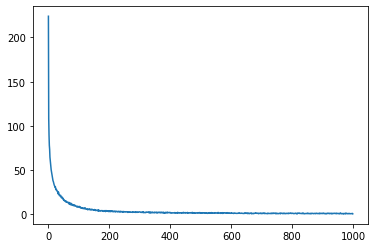

In [57]:
#We can plot the loss during the training process to visualize how the model adapts to the data.
plt.plot(history.history["loss"])
plt.show()

In [58]:
#As we might remember, the only trainable part of the model, was the one used to produce the embeddings.
#This part of the model is extracted and will be put into test usint the testing set.
model = net.get_layer(name="sequential_2")

In [59]:
#Since the data used for training was nornalized first, then we do the same with the testing set.
from sklearn.preprocessing import StandardScaler
x_test = StandardScaler().fit_transform(x_test) # normalizing the features

print(x_test.shape)

#We produce the new embeddings including the contextual information processed, to check its metrics.
result = model.predict(x_test)

print(result.shape)

(10246, 1036)
(10246, 2288)


In [60]:
#We use eucliudean distance, since is the kind of distance that was used during the training. And calculate every
#Distance between the images in the test set.
from sklearn.metrics.pairwise import euclidean_distances

result = np.array(result)
print(result)

distances = euclidean_distances(result, result)
print(distances.shape)

[[1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.6169784e-32
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 ...
 [9.9985874e-01 9.9999964e-01 2.2560467e-11 ... 1.2858612e-07
  1.1276939e-01 1.0820982e-06]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 1.2070839e-34
  1.0000000e+00 1.0000000e+00]]
(10246, 10246)


In [61]:
#For the test set, a subset of images needs to be selected as query, and the rest is used for the gallery, so no 
#image in the query should exist in the gallery, otherwise the distance would be zero. To ensure that this does 
#not happen, we first change the value to infinity to the distance of every image with itself.
querys = []
verification =  []
    
i = 0
for row in distances:
    row[i]=np.inf
    distances[i] = row
    i = i+1
    
random.seed(20)

#Then we take 20 percent of the test set for querys and the rest for gallery, as it is shown below.
numlst = list(range(len(distances))) 
random.shuffle(numlst)

split = int(len(distances)*0.2)

queryIndexes = numlst[:split]

#In order to calculate the metrics, we take a relevant subset of the ordered data, because at a certain point, the
#rest of the data is not relevant for mean Average Prceision calculation.     
mostRelevantIndices = int(len(distances)*0.75)
    
for queryIndex in queryIndexes:
    top_20_idx = np.argsort(distances[queryIndex])[:mostRelevantIndices]
    top_20_values = [distances[queryIndex][i] for i in top_20_idx]
    querys.append(top_20_idx)
    verification.append(top_20_values)

In [62]:
eucDist = [] 
areSame = []
qI = []
rI = []
Id = y_test

#We calculate for each query image against the gallery, its most closest (and therefore more similar) images. Then
#we verify if they are the same, and save the query and gallery indexes, as well as the distances between them.
i = 0
for query in querys:
    for j in range(mostRelevantIndices):
        eucDist.append(verification[i][j])
        areSame.append(int(y_test[query[j]]==y_test[queryIndexes[i]]))
        qI.append(y_test[queryIndexes[i]])
        rI.append(y_test[query[j]])
    i=i+1
    
data3Final = []
data3Final = pd.DataFrame(data3Final)

data3Final['eucDist'] = eucDist
data3Final['areSame'] = areSame
data3Final['qI'] = qI
data3Final['rI'] = rI

print(data3Final)

            eucDist  areSame  qI   rI
0          1.355377        1  15   15
1          1.571536        1  15   15
2          1.632909        1  15   15
3          1.640272        1  15   15
4          1.694714        1  15   15
...             ...      ...  ..  ...
15744511  34.151237        0  15  286
15744512  34.151501        0  15  495
15744513  34.151512        0  15  403
15744514  34.151913        0  15  266
15744515  34.152027        0  15  266

[15744516 rows x 4 columns]


In [63]:
from argparse import ArgumentParser, FileType
from importlib import import_module
from itertools import count
import os

import json
import numpy as np
from sklearn.metrics import average_precision_score

average_precision = average_precision_score

# Loop over the query embeddings and compute their APs and the CMC curve.
aps = []
cmc = np.zeros(split, dtype=np.int32)

distances = np.array(data3Final['eucDist'])
pid_matches = np.array(data3Final['areSame'])

print(pid_matches)

[1 1 1 ... 0 0 0]


In [64]:
scores = 1 / (1 + distances)

for i in range(split):
    ap = average_precision(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices], scores[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices])

    if np.isnan(ap):
        print()
        print("WARNING: encountered an AP of NaN!")
        print("This usually means a person only appears once.")
        print("In this case, it's because of {}.".format(i))
        print("I'm excluding this person from eval and carrying on.")
        print()
        continue

    aps.append(ap)
    # Find the first true match and increment the cmc data from there on.
    try:
        k = np.where(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices] == 1)[0][0]
    except:
        k = -1
    cmc[k:] += 1

# Compute the actual cmc and mAP values
cmc = cmc / split
mean_ap = np.mean(aps)

# Save important data
#if args.filename is not None:
#    json.dump({'mAP': mean_ap, 'CMC': list(cmc), 'aps': list(aps)}, args.filename)

# Print out a short summary.
print('mAP: {:.2%} | top-1: {:.2%} top-2: {:.2%} | top-5: {:.2%} | top-10: {:.2%}'.format(mean_ap, cmc[0], cmc[1], cmc[4], cmc[9]))

/home/dell_mserver_01/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



This usually means a person only appears once.
In this case, it's because of 94.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 217.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 278.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 297.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 360.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 428.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 437.
I'm excluding this person from eval and carrying on.


This usually means a person only appears 

### Original evaluation.

In [65]:
import torch
import csv
import numpy as np
import pandas as pd
from sklearn.utils import resample

random.seed(20)

data = pd.read_csv('./9Data Features and Context csv/data3MLFN.csv', sep='|', low_memory=False)
data2 = pd.DataFrame(data)

#Data is randomized to partition for training and testing.
data2 = shuffle(data2, random_state = 15)
data2.reset_index(drop=True, inplace=True)

total_instances = len(data2['Id'])

train_test_split = int(total_instances*0.3)

#Removing the contextual data and only preserving the original embedding, as produced by the algorithm.
aditionalData = ["C", "Lat", "Long", "Time", "preInt", "temp", "hum", "press", "WindS", "WindG", "CloudC", "Visb"]

data2_feats = data2.drop(aditionalData, axis = 1)

y = np.array(data2['Id'])
x = data2_feats.loc[:, data2_feats.columns != 'Id']
x = np.array(x.loc[:, x.columns != 'I'])

x_test = x[:train_test_split]
y_test = y[:train_test_split]

print(x_test.shape)

(10246, 1024)


In [66]:
from sklearn.metrics.pairwise import euclidean_distances

result = np.array(x_test)
print(result)

distances = euclidean_distances(result, result)
print(distances.shape)

[[0.41490215 0.46199965 0.         ... 0.02284668 0.03274144 0.        ]
 [0.         0.         0.79029369 ... 0.0155587  0.         0.        ]
 [0.41960859 0.25265676 0.         ... 0.         0.08890165 0.29452676]
 ...
 [0.31347814 0.34485555 0.         ... 0.17695056 0.01337142 0.41465464]
 [0.42060575 0.45297992 0.         ... 0.11389375 0.11546945 0.22706878]
 [0.0626251  0.49469495 0.04554345 ... 1.1323036  0.         0.03551469]]
(10246, 10246)


In [67]:
querys = []
verification =  []

i = 0
for row in distances:
    row[i]=np.inf
    distances[i] = row
    i = i+1

random.seed(20)

numlst = list(range(len(distances))) 
random.shuffle(numlst)

split = int(len(distances)*0.2)

queryIndexes = numlst[:split]
     
mostRelevantIndices = int(len(distances)*0.75)
    
for queryIndex in queryIndexes:
    top_20_idx = np.argsort(distances[queryIndex])[:mostRelevantIndices]
    top_20_values = [distances[queryIndex][i] for i in top_20_idx]
    querys.append(top_20_idx)
    verification.append(top_20_values)

In [68]:
eucDist = [] 
areSame = []
qI = []
rI = []
Id = y_test
    
i = 0
for query in querys:
    for j in range(mostRelevantIndices):
        eucDist.append(verification[i][j])
        areSame.append(int(y_test[query[j]]==y_test[queryIndexes[i]]))
        qI.append(y_test[queryIndexes[i]])
        rI.append(y_test[query[j]])
    i=i+1
    
data3Final = []
data3Final = pd.DataFrame(data3Final)

data3Final['eucDist'] = eucDist
data3Final['areSame'] = areSame
data3Final['qI'] = qI
data3Final['rI'] = rI

print(data3Final)

            eucDist  areSame  qI   rI
0          1.137081        1  15   15
1          1.139050        1  15   15
2          1.347188        1  15   15
3          1.453969        1  15   15
4          1.456701        1  15   15
...             ...      ...  ..  ...
15744511  14.884853        0  15  278
15744512  14.885455        0  15  202
15744513  14.885826        0  15  236
15744514  14.887174        0  15  236
15744515  14.887429        0  15  195

[15744516 rows x 4 columns]


In [69]:
from argparse import ArgumentParser, FileType
from importlib import import_module
from itertools import count
import os

import json
import numpy as np
from sklearn.metrics import average_precision_score


average_precision = average_precision_score

# Loop over the query embeddings and compute their APs and the CMC curve.
aps = []
cmc = np.zeros(split, dtype=np.int32)

distances = np.array(data3Final['eucDist'])
pid_matches = np.array(data3Final['areSame'])

print(pid_matches)

[1 1 1 ... 0 0 0]


In [70]:
scores = 1 / (1 + distances)

for i in range(split):
    ap = average_precision(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices], scores[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices])

    if np.isnan(ap):
        print()
        print("WARNING: encountered an AP of NaN!")
        print("This usually means a person only appears once.")
        print("In this case, it's because of {}.".format(i))
        print("I'm excluding this person from eval and carrying on.")
        print()
        continue

    aps.append(ap)
    # Find the first true match and increment the cmc data from there on.
    try:
        k = np.where(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices] == 1)[0][0]
    except:
        k = -1
    cmc[k:] += 1

# Compute the actual cmc and mAP values
cmc = cmc / split
mean_ap = np.mean(aps)

# Save important data
#if args.filename is not None:
#    json.dump({'mAP': mean_ap, 'CMC': list(cmc), 'aps': list(aps)}, args.filename)

# Print out a short summary.
print('mAP: {:.2%} | top-1: {:.2%} top-2: {:.2%} | top-5: {:.2%} | top-10: {:.2%}'.format(mean_ap, cmc[0], cmc[1], cmc[4], cmc[9]))

/home/dell_mserver_01/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



This usually means a person only appears once.
In this case, it's because of 94.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 217.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 278.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 297.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 360.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 428.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 437.
I'm excluding this person from eval and carrying on.


This usually means a person only appears 

# Memory cleaning

In [71]:
import torch, gc
gc.collect()

torch.cuda.empt
y_cache()

AttributeError: module 'torch.cuda' has no attribute 'empt'